# Изучение архитектуры на основе U-Net в PyTorch

## Импорт необходимых библиотек

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
сolab_requirements = ["pip install albumentations==0.4.6",]

import sys, subprocess

def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in сolab_requirements:
        run_subprocess_command(i)

In [ ]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

import albumentations
from albumentations.pytorch import ToTensorV2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
def torch_stats():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)

    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn

In [ ]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.0
Using device: cuda
cuda:  2.0.0
Cuda is available: True
number of devices: 2
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers: 4


Упражнения

** 1**

1. Преобразуйте моедль `UNet` в `DeconvNet`, сравните результаты.

2. Попробуйте полную модель `UNet`, например от сюда  https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py или https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py. Сравните результат с не полной моделью.

## 1. Преобразуйте моедль UNet в DeconvNet, сравните результаты.

### Загрузим данные

In [ ]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [ ]:
url_images = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
root_directory = os.path.join(os.getcwd(),'data','pets')

archive_name = url_images.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_images, root_directory)


url_anno   = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

archive_name = url_anno.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_anno, root_directory)

100%|██████████| 791918971/791918971 [00:21<00:00, 36941243.23it/s]


Extracting /kaggle/working/data/pets/images.tar.gz to /kaggle/working/data/pets


100%|██████████| 19173078/19173078 [00:01<00:00, 13965696.02it/s]


Extracting /kaggle/working/data/pets/annotations.tar.gz to /kaggle/working/data/pets


In [ ]:
content = os.listdir(root_directory)
print(content)
print('n images = ',len(os.listdir(os.path.join(root_directory, 'images'))))

['images.tar.gz', 'annotations.tar.gz', 'annotations', 'images']
n images =  7393


In [ ]:
N_TRAIN = 6000
N_TEST  = 100
STEP    = 5

images_directory = os.path.join(root_directory, "images")
masks_directory  = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = os.listdir(images_directory)

images_filenames = [i for i in images_filenames
                        if os.path.splitext(i)[-1]
                            in ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')]
os.path.splitext('/path/to/somefile.ext')

random.shuffle(images_filenames)

train_images_filenames = images_filenames[:N_TRAIN:STEP]
val_images_filenames   = images_filenames[N_TRAIN:-N_TEST:STEP]
test_images_filenames  = images_filenames[-N_TEST::STEP]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

1200 258 20


Создадим класс для преобразовании данных к нужному виду

In [ ]:
from torch.utils.data import Dataset

class PetsDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transforms=None):

        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory  = masks_directory

        self.transforms = transforms

    def __len__(self):
        return len(self.images_filenames)

    def preprocess_mask(self, mask):
        mask = np.asarray(mask).astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask

    def __getitem__(self, idx):

        image_filename = self.images_filenames[idx]

        path_ = os.path.join(self.images_directory, image_filename)
        image = np.asarray(Image.open(path_).convert("RGB"))

        path_ = os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png"))
        mask  = Image.open(path_)
        mask  = self.preprocess_mask(mask)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask  = transformed["mask"]

        return image, mask

In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = A.Compose([A.Resize(280, 280),
                             A.RandomCrop(256,256),
                             A.ShiftScaleRotate(0.2,0.2, 30),
                             A.RGBShift(25,25,25),
                             A.RandomBrightnessContrast(0.3,0.3),
                             A.Normalize(mean, std),
                             ToTensorV2(),])

test_transform = A.Compose([A.Resize(256, 256),
                            A.Normalize(mean, std),
                            ToTensorV2()])

train_dataset = PetsDataset(train_images_filenames, images_directory, masks_directory, transforms=train_transform,)

val_dataset   = PetsDataset(val_images_filenames,   images_directory, masks_directory, transforms=test_transform,)

test_dataset  = PetsDataset(test_images_filenames,  images_directory, masks_directory, transforms=test_transform,)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1200
Valid size: 258
Test size: 20


Визуализируем данные - маска и само изображение

In [ ]:
from PIL import Image
def visualize_dataset(dataset, samples=5, predicted_masks = None, mean = mean, std = std):
    dataset = copy.deepcopy(dataset)
    cols = 3 if predicted_masks else 2

    figure, ax = plt.subplots(nrows=samples, ncols=cols, figsize=(10, 12))

    for i in range(samples):
        image, mask = dataset[i]

        image = image.data.cpu().numpy().transpose((1,2,0))
        image = np.clip(image*std + mean,0,1)

        mask = np.clip(mask,0,1)


        ax[i, 0].imshow(image)
        ax[i, 0].set_title("Image"); ax[i, 0].set_axis_off()
        ax[i, 1].imshow(mask.data.cpu().numpy(), interpolation="nearest")
        ax[i, 1].set_title("Ground Truth");  ax[i, 1].set_axis_off()
        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted Mask"); ax[i, 2].set_axis_off()

    plt.tight_layout()
    plt.show()

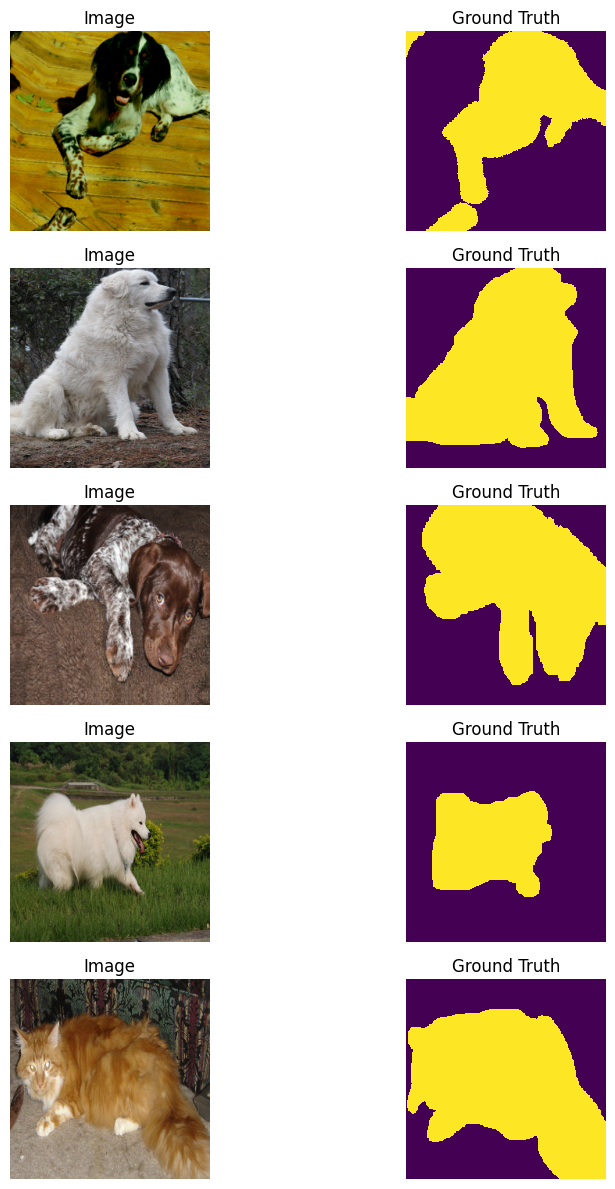

In [ ]:
visualize_dataset(train_dataset, samples=5)

Необходимо подать данные в DataLoader для дальнейшей работы

In [ ]:
BATCH = 4

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda'), 'pin_memory':True}
else:
     kwarg = {'num_workers':0}

train_loader = DataLoader(
                train_dataset,
                batch_size=BATCH,
                shuffle=True,
                **kwarg)

val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH,
                shuffle=False,
                **kwarg)

test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH,
                shuffle=False,
                **kwarg)

Архитектура UNET

Для начала рассмотрим модель UNET и посмотрим на результат

In [ ]:
SIZE = 32

def conv_block(in_channels, out_channels, mid_channels = None):
    if mid_channels is None:
        mid_channels = out_channels

    return nn.Sequential(
        nn.Conv2d(in_channels,  mid_channels, 3, padding=1, bias = False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, 3, padding=1, bias = False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True))

class UNet(nn.Module):

    def __init__(self, n_channels = 1, n_class=1):
        super().__init__()

        self.down1 = conv_block(n_channels, SIZE)
        self.down2 = conv_block(SIZE,       SIZE*2)
        self.down3 = conv_block(SIZE*2,     SIZE*4)
        self.down4 = conv_block(SIZE*4,     SIZE*8)

        self.maxpool  = nn.MaxPool2d(2)

        self.upsample = nn.Upsample(scale_factor=2,
                                    mode='bilinear',
                                    align_corners=True)


        self.up3 = conv_block(SIZE*4 + SIZE*8, SIZE*4)
        self.up2 = conv_block(SIZE*2 + SIZE*4, SIZE*2)
        self.up1 = conv_block(SIZE*2 + SIZE,   SIZE)

        self.out = nn.Conv2d(SIZE, n_class, 3, padding=1)

    #---------------------------------------------
    def forward(self, x):

        #ENCODER
        conv1 = self.down1(x)
        x = self.maxpool(conv1)

        conv2 = self.down2(x)
        x = self.maxpool(conv2)

        conv3 = self.down3(x)
        x = self.maxpool(conv3)

        x = self.down4(x)

        #DECODER
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.up1(x)

        out = self.out(x)

        return out

In [ ]:
model = UNet(n_channels=3, n_class=1)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

In [ ]:
def dice_loss(pred, target, smooth=1):
    #flatten label and prediction tensors

    pred    = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    loss = 1 - (2.*intersection + smooth)/(pred.sum() + target.sum() + smooth)

    return loss

class DiceBCELoss(nn.Module):
    def __init__(self, weight=1):
        super().__init__()
        self.weight = weight

    def forward(self, pred, target, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        pred = torch.sigmoid(pred)

        dice = dice_loss(pred, target, smooth=1)

        bce = F.binary_cross_entropy(pred.squeeze(), target.squeeze(), reduction='mean')
        dice_bce = self.weight*bce + dice*(1-self.weight)

        return dice_bce

In [ ]:
LR = 0.001

model = model.to(device)

criterion = DiceBCELoss(weight = 0.5)

criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
def accuracy(y_pred, y):
    return 1-dice_loss(torch.sigmoid(y_pred), y, smooth=1)

#-----------------------------
def train(model, dataloader, optimizer, criterion, metrics, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metrics( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#--------------------------
def evaluate(model, dataloader, criterion,metrics, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metrics( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def init_weights(m):

    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if m.bias != None:
            m.bias.data.fill_(0)

model.apply(init_weights);

Проведем обучение модели

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                train_loader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   val_loader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 0.456 | Train Acc: 65.25%
	 Val. Loss: 0.502 |  Val. Acc: 65.71%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.421 | Train Acc: 68.26%
	 Val. Loss: 0.549 |  Val. Acc: 66.51%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 0.395 | Train Acc: 70.42%
	 Val. Loss: 0.408 |  Val. Acc: 70.22%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 33s
	Train Loss: 0.369 | Train Acc: 72.57%
	 Val. Loss: 0.303 |  Val. Acc: 75.03%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 34s
	Train Loss: 0.352 | Train Acc: 73.90%
	 Val. Loss: 0.305 |  Val. Acc: 73.71%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 33s
	Train Loss: 0.340 | Train Acc: 74.96%
	 Val. Loss: 0.300 |  Val. Acc: 76.23%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 34s
	Train Loss: 0.319 | Train Acc: 76.52%
	 Val. Loss: 0.261 |  Val. Acc: 78.78%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 34s
	Train Loss: 0.305 | Train Acc: 77.69%
	 Val. Loss: 0.275 |  Val. Acc: 77.82%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 34s
	Train Loss: 0.303 | Train Acc: 78.02%
	 Val. Loss: 0.295 |  Val. Acc: 74.49%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 33s
	Train Loss: 0.286 | Train Acc: 79.20%
	 Val. Loss: 0.243 |  Val. Acc: 79.04%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

-------------------- 
best epoch 16: Test Loss: 0.235 | Test Acc: 81.38%


In [ ]:
x,y = next(iter(val_loader))

x = x.to(device)
y = y.to(device)

y_pred = torch.sigmoid(model.forward(x))
y_pred.shape

torch.Size([4, 1, 256, 256])

Визуализируем то, что выдает модель для изображения из валидационной выборки

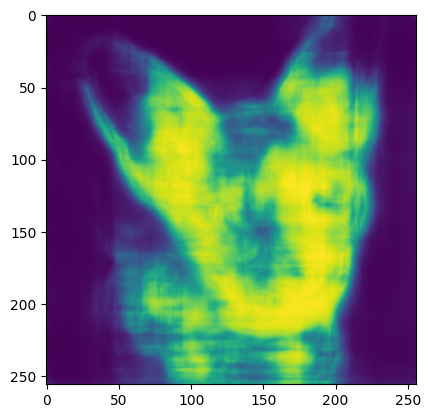

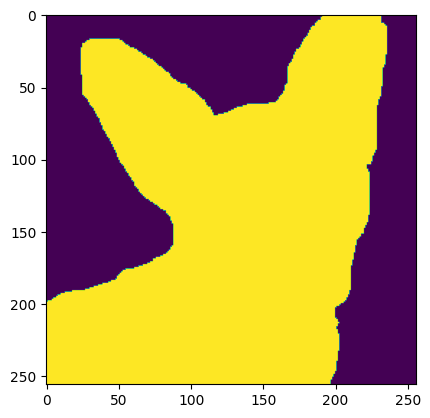

In [ ]:
id = 3
plt.imshow(y_pred[id,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[id,:,:].detach().cpu().numpy()); plt.show()

Рассмотрим модель DeconvNet

Заменим слой из Unet (nn.Upsample) на слой  nn.ConvTranspose2d

In [ ]:
import torch.nn.functional as F

SIZE = 32

def conv_block(in_channels, out_channels, mid_channels=None):
    if mid_channels is None:
        mid_channels = out_channels

    return nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, 3, padding=1, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, 3, padding=1, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True))

class DeconvNet(nn.Module):

    def __init__(self, n_channels=1, n_class=1):
        super(DeconvNet, self).__init__()

        self.down1 = conv_block(n_channels, SIZE)
        self.down2 = conv_block(SIZE, SIZE*2)
        self.down3 = conv_block(SIZE*2, SIZE*4)
        self.down4 = conv_block(SIZE*4, SIZE*8)


        self.upsample3 = nn.ConvTranspose2d(SIZE*8, SIZE*8, kernel_size=2, stride=2)
        self.up3 = conv_block(SIZE*4 + SIZE*8, SIZE*4)

        self.upsample2 = nn.ConvTranspose2d(SIZE*4, SIZE*4, kernel_size=2, stride=2)
        self.up2 = conv_block(SIZE*2 + SIZE*4, SIZE*2)

        self.up1 = conv_block(SIZE*2, SIZE)
        self.upsample1 = nn.ConvTranspose2d(SIZE*2, SIZE, kernel_size=2, stride=2)

        self.out = nn.Conv2d(SIZE, n_class, 3, padding=1)

    def forward(self, x):

        # ENCODER
        conv1 = self.down1(x)
        x = F.max_pool2d(conv1, 2)


        conv2 = self.down2(x)
        x = F.max_pool2d(conv2, 2)

        conv3 = self.down3(x)
        x = F.max_pool2d(conv3, 2)

        x = self.down4(x)


        # DECODER
        x = self.upsample3(x)
        x = torch.cat([x, conv3], dim=1)


        x = self.up3(x)

        x = self.upsample2(x)

        x = torch.cat([x, conv2], dim=1)



        x = self.up2(x)

        x = self.upsample1(x)

        x = torch.cat([x, conv1], dim=1)



        x = self.up1(x)


        out = self.out(x)

        return out

# Assuming SIZE is a predefined variable representing the number of channels
SIZE = 32
model = DeconvNet(n_channels=3, n_class=1)
summary(model, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 64, 128, 128]          18,432
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          36,864
      BatchNorm2d-11         [-1, 64, 128, 128]             128
             ReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13          [-1, 128, 64, 64]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
LR = 0.001

model = model.to(device)

criterion = DiceBCELoss(weight = 0.5)

criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
model.apply(init_weights);

Обучим модель

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                train_loader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   val_loader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 0.464 | Train Acc: 64.51%
	 Val. Loss: 0.415 |  Val. Acc: 69.21%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 42s
	Train Loss: 0.419 | Train Acc: 68.52%
	 Val. Loss: 0.372 |  Val. Acc: 68.21%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 42s
	Train Loss: 0.394 | Train Acc: 70.52%
	 Val. Loss: 0.366 |  Val. Acc: 70.80%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 42s
	Train Loss: 0.383 | Train Acc: 71.45%
	 Val. Loss: 0.350 |  Val. Acc: 69.65%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 42s
	Train Loss: 0.359 | Train Acc: 73.53%
	 Val. Loss: 0.341 |  Val. Acc: 75.68%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 42s
	Train Loss: 0.356 | Train Acc: 73.64%
	 Val. Loss: 0.293 |  Val. Acc: 74.50%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 42s
	Train Loss: 0.337 | Train Acc: 75.12%
	 Val. Loss: 0.308 |  Val. Acc: 75.43%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 42s
	Train Loss: 0.323 | Train Acc: 76.42%
	 Val. Loss: 0.271 |  Val. Acc: 77.85%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 42s
	Train Loss: 0.314 | Train Acc: 77.11%
	 Val. Loss: 0.301 |  Val. Acc: 75.56%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 42s
	Train Loss: 0.308 | Train Acc: 77.48%
	 Val. Loss: 0.266 |  Val. Acc: 77.27%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

-------------------- 
best epoch 16: Test Loss: 0.257 | Test Acc: 77.42%


Качество немного ниже, чем классическая UNET. Это также может быть связано с тем, что модель недообучилась до конца, поскольку loss продолжает падать.
Accuracy на тестовой выборке составило 81%, а для случая DecovNet - 77%

In [ ]:
x,y = next(iter(val_loader))

x = x.to(device)
y = y.to(device)

y_pred = torch.sigmoid(model.forward(x))
y_pred.shape

torch.Size([4, 1, 256, 256])

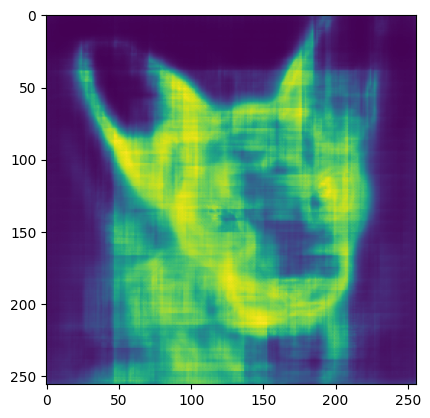

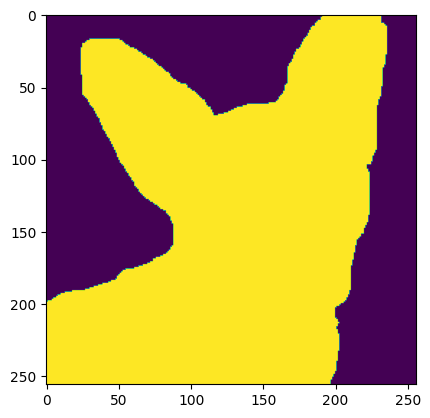

In [ ]:
id = 3
plt.imshow(y_pred[id,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[id,:,:].detach().cpu().numpy()); plt.show()

Также видно, что модель не так уверенно обозначает границы изображения (подсветка объекта меньшей интенсивности)

## 2. Попробуйте полную модель UNet

Рассмотрим полную модель UNET и сравним ее с моделью из упражнения 1.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
SIZE = 32
model = UNet(n_channels=3, n_classes=1)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [ ]:
LR = 0.001

model = model.to(device)

criterion = DiceBCELoss(weight = 0.5)

criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
model.apply(init_weights);

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                train_loader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   val_loader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 46s
	Train Loss: 0.445 | Train Acc: 66.03%
	 Val. Loss: 0.411 |  Val. Acc: 63.94%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 46s
	Train Loss: 0.406 | Train Acc: 69.38%
	 Val. Loss: 0.398 |  Val. Acc: 69.28%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 47s
	Train Loss: 0.387 | Train Acc: 71.20%
	 Val. Loss: 0.333 |  Val. Acc: 71.57%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 47s
	Train Loss: 0.376 | Train Acc: 71.86%
	 Val. Loss: 0.321 |  Val. Acc: 73.50%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 46s
	Train Loss: 0.358 | Train Acc: 73.39%
	 Val. Loss: 0.335 |  Val. Acc: 75.09%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 47s
	Train Loss: 0.340 | Train Acc: 74.99%
	 Val. Loss: 0.283 |  Val. Acc: 76.02%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 47s
	Train Loss: 0.319 | Train Acc: 76.56%
	 Val. Loss: 0.266 |  Val. Acc: 78.58%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 47s
	Train Loss: 0.309 | Train Acc: 77.24%
	 Val. Loss: 0.262 |  Val. Acc: 77.43%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 47s
	Train Loss: 0.295 | Train Acc: 78.48%
	 Val. Loss: 0.262 |  Val. Acc: 81.17%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 46s
	Train Loss: 0.282 | Train Acc: 79.25%
	 Val. Loss: 0.257 |  Val. Acc: 81.22%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

-------------------- 
best epoch 18: Test Loss: 0.240 | Test Acc: 81.01%


Результат работы полной модели не отличается от модели, рассмотренной в первом упражнении.

In [ ]:
x,y = next(iter(val_loader))

x = x.to(device)
y = y.to(device)

y_pred = torch.sigmoid(model.forward(x))
y_pred.shape

torch.Size([4, 1, 256, 256])

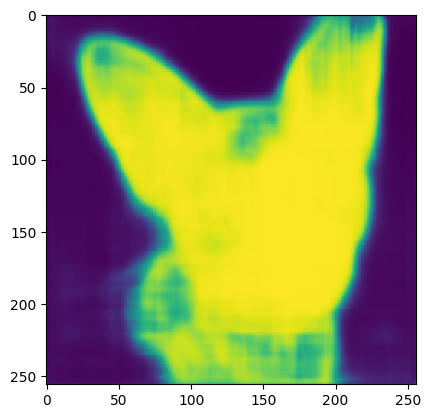

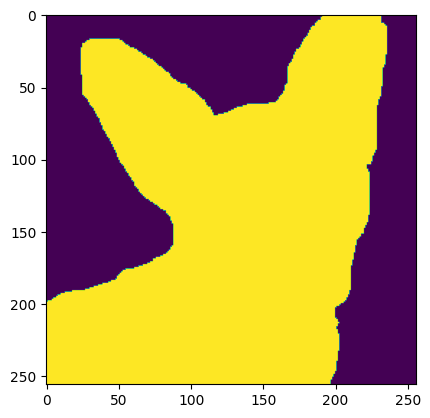

In [ ]:
id = 3
plt.imshow(y_pred[id,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[id,:,:].detach().cpu().numpy()); plt.show()

Однако, видно, что подсветка изображения наиболее интенсивная, чем для модели в 1 упражнении.

## **Упражнение 2** <br>
Изучите библиотеку готовых моделей [`segmentation_models_pytorch`](https://github.com/qubvel/segmentation_models.pytorch). Тут [официальная документация](https://segmentation-modelspytorch.readthedocs.io/en/latest/) и тут  [уроки](https://github.com/qubvel/segmentation_models.pytorch/tree/master/examples).  Для нашего случая пример использования библиотеки может быть следующим.

Сравните несколько моделей из SMP [можно найти тут](https://github.com/qubvel/segmentation_models.pytorch#models) с несколькими энкодерами [можно найти тут](https://github.com/qubvel/segmentation_models.pytorch#encoders).

### Рассмотрим модель MAnet c энкодером efficientnet-b0

In [ ]:
try:
    import segmentation_models_pytorch
except:
    !pip install segmentation_models_pytorch

import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained efficientnet backbone
model = smp.MAnet(encoder_name="efficientnet-b0", encoder_weights="imagenet", classes=1,)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 106MB/s] 


In [ ]:
LR = 0.001
model = model.to(device)
criterion = DiceBCELoss(weight = 0.5)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                train_loader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   val_loader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 36s
	Train Loss: 0.253 | Train Acc: 82.20%
	 Val. Loss: 0.206 |  Val. Acc: 84.29%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 36s
	Train Loss: 0.205 | Train Acc: 85.80%
	 Val. Loss: 0.141 |  Val. Acc: 89.35%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 36s
	Train Loss: 0.200 | Train Acc: 86.08%
	 Val. Loss: 0.153 |  Val. Acc: 87.54%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 36s
	Train Loss: 0.176 | Train Acc: 87.98%
	 Val. Loss: 0.129 |  Val. Acc: 90.82%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 36s
	Train Loss: 0.177 | Train Acc: 87.76%
	 Val. Loss: 0.143 |  Val. Acc: 88.79%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 36s
	Train Loss: 0.196 | Train Acc: 86.31%
	 Val. Loss: 0.135 |  Val. Acc: 89.15%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 36s
	Train Loss: 0.163 | Train Acc: 88.79%
	 Val. Loss: 0.136 |  Val. Acc: 89.46%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 36s
	Train Loss: 0.151 | Train Acc: 89.52%
	 Val. Loss: 0.118 |  Val. Acc: 90.69%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 36s
	Train Loss: 0.143 | Train Acc: 90.11%
	 Val. Loss: 0.127 |  Val. Acc: 89.71%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 36s
	Train Loss: 0.139 | Train Acc: 90.35%
	 Val. Loss: 0.122 |  Val. Acc: 90.68%


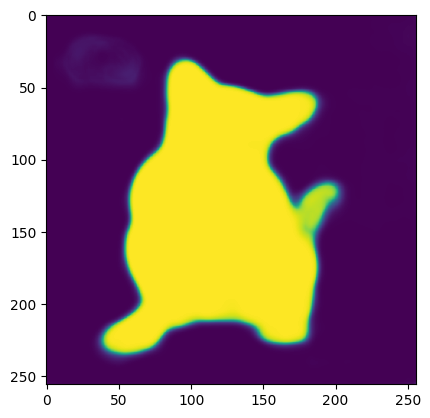

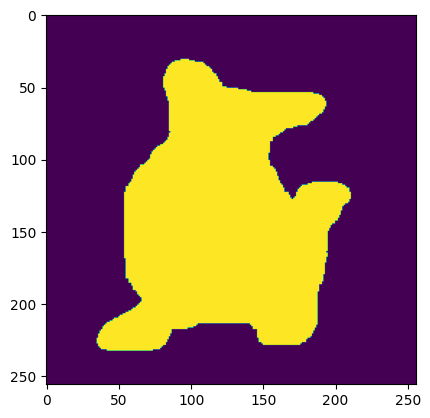

In [ ]:
x,y = next(iter(val_loader))
x = x.to(device)
y = y.to(device)
y_pred = torch.sigmoid(model.forward(x))
plt.imshow(y_pred[1,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[1,:,:].detach().cpu().numpy()); plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

-------------------- 
best epoch 16: Test Loss: 0.116 | Test Acc: 91.94%


Accuracy - 91.9% это намного выше результата, который был достигнут моделью Unet написанной нами.

Рассмотрим эту же модель MAnet, но с другим энкодером mobilenet_v2

In [ ]:
model = smp.MAnet(encoder_name="mobilenet_v2", encoder_weights="imagenet", classes=1,)

In [ ]:
LR = 0.001
model = model.to(device)
criterion = DiceBCELoss(weight = 0.5)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                train_loader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   val_loader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 0.307 | Train Acc: 77.42%
	 Val. Loss: 0.238 |  Val. Acc: 80.99%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 42s
	Train Loss: 0.252 | Train Acc: 81.73%
	 Val. Loss: 0.190 |  Val. Acc: 84.66%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 42s
	Train Loss: 0.248 | Train Acc: 82.24%
	 Val. Loss: 0.175 |  Val. Acc: 85.60%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 42s
	Train Loss: 0.223 | Train Acc: 84.06%
	 Val. Loss: 0.159 |  Val. Acc: 87.08%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 42s
	Train Loss: 0.200 | Train Acc: 85.82%
	 Val. Loss: 0.153 |  Val. Acc: 87.52%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 42s
	Train Loss: 0.267 | Train Acc: 80.75%
	 Val. Loss: 0.212 |  Val. Acc: 82.67%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 42s
	Train Loss: 0.221 | Train Acc: 84.22%
	 Val. Loss: 0.170 |  Val. Acc: 86.05%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 42s
	Train Loss: 0.198 | Train Acc: 85.99%
	 Val. Loss: 0.149 |  Val. Acc: 88.70%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 42s
	Train Loss: 0.226 | Train Acc: 83.83%
	 Val. Loss: 0.161 |  Val. Acc: 87.71%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 42s
	Train Loss: 0.198 | Train Acc: 85.98%
	 Val. Loss: 0.153 |  Val. Acc: 87.61%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

-------------------- 
best epoch 15: Test Loss: 0.149 | Test Acc: 88.70%


Accuracy  - 88.7%, это ниже результата достигнутого моделью при использовании энкодера efficientnet-b0

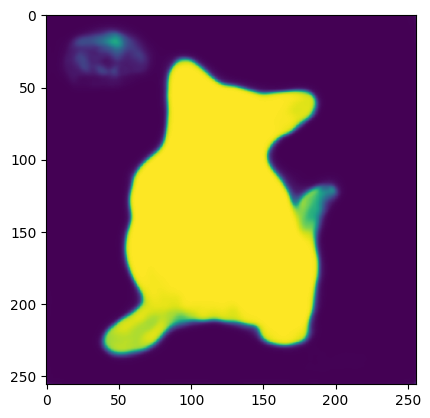

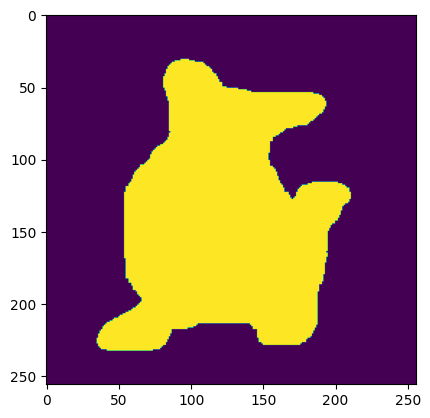

In [ ]:
x,y = next(iter(val_loader))
x = x.to(device)
y = y.to(device)
y_pred = torch.sigmoid(model.forward(x))
plt.imshow(y_pred[1,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[1,:,:].detach().cpu().numpy()); plt.show()

Рассмотрим модель Linknet с энкодером efficientnet-b0

In [ ]:
model = smp.Linknet(encoder_name="efficientnet-b0", encoder_weights="imagenet", classes=1,)

In [ ]:
LR = 0.001
model = model.to(device)
criterion = DiceBCELoss(weight = 0.5)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                train_loader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   val_loader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 0.258 | Train Acc: 81.82%
	 Val. Loss: 0.176 |  Val. Acc: 85.79%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 0.215 | Train Acc: 84.88%
	 Val. Loss: 0.176 |  Val. Acc: 87.35%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 0.186 | Train Acc: 87.06%
	 Val. Loss: 0.140 |  Val. Acc: 88.87%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 0.171 | Train Acc: 88.08%
	 Val. Loss: 0.142 |  Val. Acc: 88.98%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 30s
	Train Loss: 0.151 | Train Acc: 89.54%
	 Val. Loss: 0.142 |  Val. Acc: 89.74%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 30s
	Train Loss: 0.147 | Train Acc: 89.70%
	 Val. Loss: 0.117 |  Val. Acc: 90.99%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 30s
	Train Loss: 0.139 | Train Acc: 90.48%
	 Val. Loss: 0.126 |  Val. Acc: 90.03%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 30s
	Train Loss: 0.128 | Train Acc: 91.17%
	 Val. Loss: 0.120 |  Val. Acc: 90.77%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 30s
	Train Loss: 0.128 | Train Acc: 91.16%
	 Val. Loss: 0.130 |  Val. Acc: 89.45%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 30s
	Train Loss: 0.128 | Train Acc: 91.23%
	 Val. Loss: 0.138 |  Val. Acc: 91.08%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

-------------------- 
best epoch 14: Test Loss: 0.116 | Test Acc: 91.02%


Accuracy - 91%, результат близок к модели MAnet с тем же энкодером, возможно такое сочетание модели и энкодера является наиболее удачным.

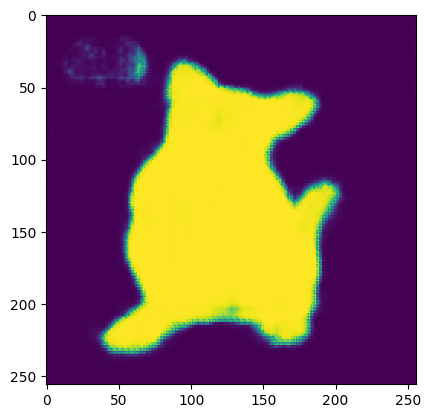

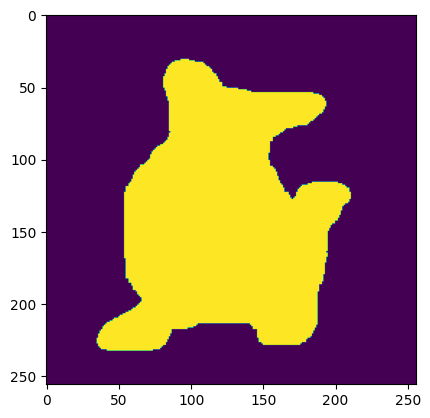

In [ ]:
x,y = next(iter(val_loader))
x = x.to(device)
y = y.to(device)
y_pred = torch.sigmoid(model.forward(x))
plt.imshow(y_pred[1,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[1,:,:].detach().cpu().numpy()); plt.show()

Модель Linknet с энкодером mobilenet_v2

In [ ]:
model = smp.Linknet(encoder_name="mobilenet_v2", encoder_weights="imagenet", classes=1,)

In [ ]:
LR = 0.001
model = model.to(device)
criterion = DiceBCELoss(weight = 0.5)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                train_loader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   val_loader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.257 | Train Acc: 81.24%
	 Val. Loss: 0.174 |  Val. Acc: 85.04%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 0.216 | Train Acc: 84.69%
	 Val. Loss: 0.173 |  Val. Acc: 87.61%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 0.207 | Train Acc: 85.38%
	 Val. Loss: 0.153 |  Val. Acc: 89.09%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 0.193 | Train Acc: 86.37%
	 Val. Loss: 0.149 |  Val. Acc: 88.86%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 23s
	Train Loss: 0.175 | Train Acc: 87.79%
	 Val. Loss: 0.137 |  Val. Acc: 89.09%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 23s
	Train Loss: 0.169 | Train Acc: 88.20%
	 Val. Loss: 0.152 |  Val. Acc: 88.46%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 23s
	Train Loss: 0.162 | Train Acc: 88.64%
	 Val. Loss: 0.136 |  Val. Acc: 89.62%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 23s
	Train Loss: 0.165 | Train Acc: 88.54%
	 Val. Loss: 0.131 |  Val. Acc: 89.63%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 23s
	Train Loss: 0.161 | Train Acc: 88.70%
	 Val. Loss: 0.132 |  Val. Acc: 89.44%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 23s
	Train Loss: 0.153 | Train Acc: 89.28%
	 Val. Loss: 0.123 |  Val. Acc: 89.83%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

-------------------- 
best epoch 19: Test Loss: 0.123 | Test Acc: 89.83%


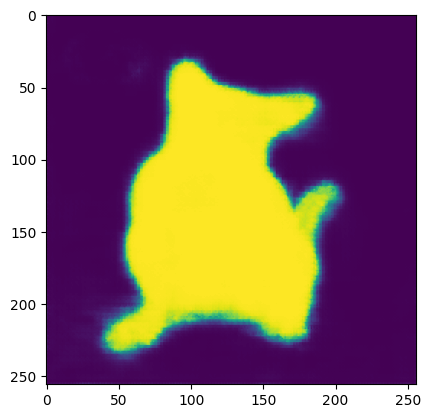

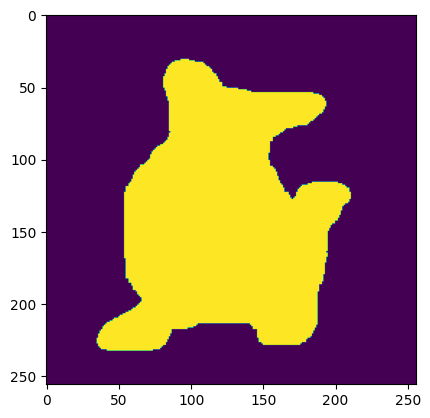

In [ ]:
x,y = next(iter(val_loader))
x = x.to(device)
y = y.to(device)
y_pred = torch.sigmoid(model.forward(x))
plt.imshow(y_pred[1,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[1,:,:].detach().cpu().numpy()); plt.show()

Accuracy - 89.9%, модель с энкодером mobilenet_v2 также как и в случае с моделью MAnet показывает результат ниже, чем с энкодером efficientnet-b0. Однако результат немного лучше, чем для модели MAnet с тем же энкодером

В данном случае, наилучший результат показала модедь MAnet с энкодером  efficientnet-b0 - accuracy = 91.9%